In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
class QLearningSolver:
    """Class containing the Q-learning algorithm that might be used for different discrete environments."""

    def __init__(
        self,
        observation_space: int,
        action_space: int,
        learning_rate: float = 0.1,
        gamma: float = 0.9,
        epsilon: float = 0.1,
    ):
        self.observation_space = observation_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon

        self.q_table = np.zeros((observation_space, action_space))

    def __call__(self, state: np.ndarray, action: np.ndarray) -> np.ndarray:
        """Return Q-value of given state and action."""
        return self.q_table[state, action]

    def update(self, state: np.ndarray, action: np.ndarray, reward: float, next_state: int) -> None:
        """Update Q-value of given state and action."""
        current_q = self.q_table[state, action]
        best_next_q = np.max(self.q_table[next_state])
        new_q = current_q + self.learning_rate * (reward + self.gamma * best_next_q - current_q)
        self.q_table[state, action] = new_q

    def get_best_action(self, state: np.ndarray) -> np.ndarray:
        """Return action that maximizes Q-value for a given state."""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_space)
        else:
            best_action = np.argmax(self.q_table[state])
            return best_action.item()

    def __repr__(self):
        """Elegant representation of Q-learning solver."""
        return f"QLearningSolver(learning_rate={self.learning_rate}, gamma={self.gamma}, epsilon={self.epsilon})"

    def __str__(self):
        return self.__repr__()

In [3]:
def train(q_solver, env, learning_iter, plots: bool, verbose: bool=False):

    num_episodes = learning_iter
    all_rewards = []
    for episode in range(num_episodes):
        state = env.reset()[0]
        done = False
        total_reward = 0
        while not done:
            action = q_solver.get_best_action(state)
            next_state, reward, done = env.step(action)[0:3]
            q_solver.update(state, action, reward, next_state)
            total_reward += reward
            state = next_state

        all_rewards.append(total_reward)
        if episode % 10 == 0 and verbose:
            print(f"Episode: {episode}, Total Reward: {total_reward}")
    if plots:
        plt.scatter(all_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total reward')
        plt.show()
    return q_solver



def tester(env_handler, q_solver, testing_iter, plot: bool, verbose: int):
    test_rewards = np.array([])
    episodes_list = [i for i in range(testing_iter)]
    for episode in range(testing_iter):
        state = env_handler.reset()[0]
        done = False
        total_reward = 0
        while not done:
            action = q_solver.get_best_action(state)
            next_state, reward, done= env_handler.step(action)[0:3]
            total_reward += reward
            state = next_state
            env_handler.render()
        test_rewards = np.append(test_rewards, [total_reward])
        if verbose == 2:
            print(f"Episode: {episode}, Total Reward: {total_reward}")
    if verbose == 1:
        print(f'Mean of reward value: {np.mean(test_rewards)}')
    if plot:
        plt.scatter(episodes_list, test_rewards)
        plt.plot(test_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total reward')
        plt.show()
    return np.mean(test_rewards)

In [4]:
# Visualisation

env = gym.make('Taxi-v3')

solver = QLearningSolver(
    observation_space=env.observation_space.n,
    action_space=env.action_space.n,
)

q_solver = train(solver, env, 2500, False, False)

test_env = gym.make('Taxi-v3',render_mode='human')

tester(test_env, q_solver, 3, False, 0)


: 

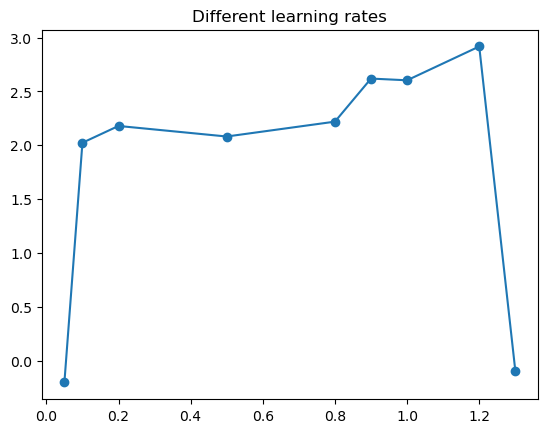

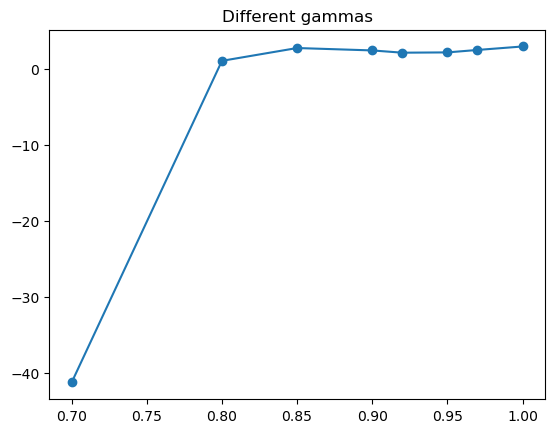

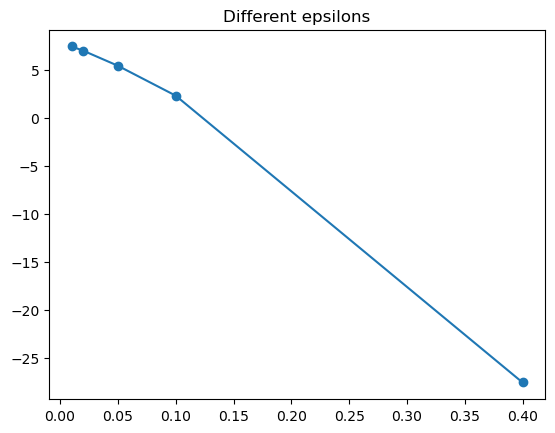

In [7]:
# Tests

learning_rates = [0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 1, 1.2, 1.3]
gammas = [0.7, 0.8, 0.85, 0.9, 0.92, 0.95, 0.97, 1]
epsilons = [0.01, 0.02, 0.05, 0.1, 0.4]
params = [learning_rates, gammas, epsilons]

for param in params:
    mean_rewards = []
    for value in param:
        env = gym.make('Taxi-v3')
        if param == learning_rates:
            q_params = [value, 0.9, 0.1]
            title = "Different learning rates"
        elif param == gammas:
            q_params = [0.1, value, 0.1]
            title = "Different gammas"
        elif param == epsilons:
            q_params = [0.1, 0.9, value]
            title = "Different epsilons"
        solver = QLearningSolver(
                observation_space=env.observation_space.n,
                action_space=env.action_space.n,
                learning_rate = q_params[0],
                gamma=q_params[1],
                epsilon=q_params[2]
            )
        q_solver = train(solver, env, 5000, False, False)
        test_env = gym.make('Taxi-v3', render_mode='ansi')
        mean_rewards.append(tester(test_env, q_solver, 500, False, 0))
    plt.plot(param, mean_rewards)
    plt.scatter(param, mean_rewards)
    plt.title(title)
    plt.show()

Wnioski:

Analizując parametry pojedynczo przy założeniu, że dwa pozostałe mają wartości domyślne, od razu widać, że najlepsze wyniki uzyskiwane są dla takich wartości parametrów, które właśnie zbliżone są do bazowych. Zdecydowanie widać, że chociażby gamma musi być bliska jedności, choć nie może być od niej większa. Relatywnie prosta sprawa jest również z parametrem epsilon, który nie może być zbyt duży - nie chcemy przecież zbyt często wybierać losowych ruchów. Dla parametru learning_rate trudno jednoznacznie wybrać jego najlepszą wartość, ponieważ niemalże dla dla każdej wartości w przedzialu do jednego rzędu wielkości więcej średnia wartość nagrody jest bardzo porównywalna.
Stąd przyjąć można, że optimum osiągać będziemy w okolicach bardzo małego epsilona ~0.01-0.05, parametru gamma bliskiego jedynki, zaś tym, który w konkretnym rozwiązaniu potencjalnie może wprowadzać jakieś zmiany będzie learning_rate.